# Dense Neural Networks

---

*You can watch a [video](https://youtu.be/MQzG1hfhow4) of this lesson if you prefer.*

---

## Recap: Linear Regression

In the [last lesson](../2-Gradient_Descent/linreg.ipynb), we explored the use of gradient descent<br>
for training a linear regression algorithm. In this lesson, we'll extend what we built to make<br>
a multi-layered dense neural network.

Actually, before we dive in, let's quickly refresh on linear regression.<br>
Say, we're trying to predict tomorrow's temperature (`tmax_tomorrow`).

To do so, we want to use:

- Today's max temperature (`tmax`), 
- Today's min temperature (`tmin`), and 
- How much it rained today (`rain`).

We call tomorrow's temperature $y$, `tmax` $x_{1}$, `tmin` $x_{2}$, and `rain` $x_{3}$.

We can then predict tomorrow's temperature using this equation:
$$\hat{y}=w_{1}x_{1} + w_{2}x_{2} + w_{3}x_{4} + b$$

$\hat{y}$ is our prediction for `tmax_tomorrow`.<br>
The $w_n$ values are called **weights**, and the $b$ value is called the **bias**.

We multiply each of our values $x_n$ by its corresponding weight $w_n$. Then we add in the bias.<br>
In the [last lesson](../2-Gradient_Descent/linreg.ipynb), we learned how to calculate the $w$ and $b$ values.

In [104]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statistics import mean
from sklearn.preprocessing import StandardScaler

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

## Nonlinearity

A big limitation of linear regression is that **the prediction will always need to be linearly related to the inputs**.<br>
In real-world data, **this is rarely the case**.

Let's say we're predicting `tmax_tomorrow` using only `tmax`.<br>
The equation is therefore simplified to $\hat{y}=w_{1}x_{1} + b$.<br>
We can arbitrarily set $w_{1}$ to $.82$, and $b$ to $11.99$.

Now, let's load in our data and graph `tmax_tomorrow` and `tmax`:

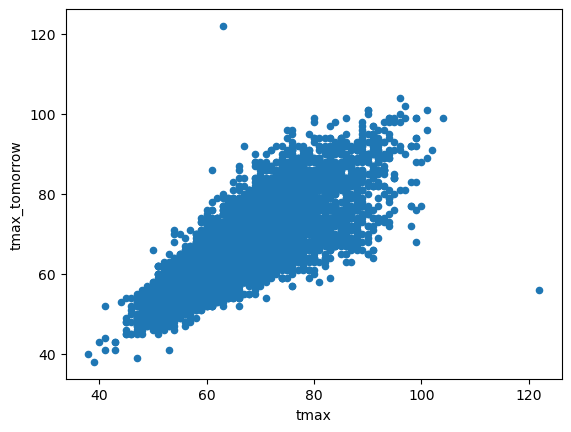

In [32]:
# Read in the data
data = pd.read_csv("../data/clean_weather.csv", index_col=0)
# Fill in any missing values in the data with past values
data = data.ffill()

# Create a scatter plot of tmax and tmax_tomorrow
data.plot.scatter("tmax", "tmax_tomorrow");

The relationship between `tmax` and `tmax_tomorrow` isn't *perfectly* linear.<br>
We can show this by drawing a regression line using $w_{1} = .82$, and $b = 11.99$:

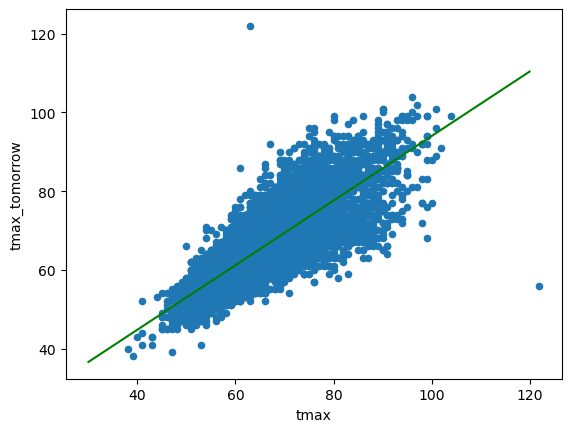

In [33]:
data.plot.scatter("tmax", "tmax_tomorrow")

# Calculate the prediction given our weight and bias
prediction = lambda x, w=.82, b=11.99: x * w + b

# Plot a linear regression line over our data
plt.plot([30, 120], [prediction(30), prediction(120)], 'green');

The line fits our data as well as a linear regression line can fit it (the mean squared error between the predictions and the actual `tmax_tomorrow` is as low as possible).

In [34]:
def mse(actual, predicted):
    # Calculate mean squared error
    return np.mean((actual - predicted) ** 2)

# Error with the weight of .82 and the bias of 11.99
print(f'Error with w=.82, b=11.99:\t{mse(data["tmax_tomorrow"], prediction(data["tmax"])):.2f}')

# Error with a small shift in our weight, to .83, and in our bias, to 12
print(f'Error with w=.83, b=12:\t\t{mse(data["tmax_tomorrow"], prediction(data["tmax"],w=.83,b=12)):.2f}')

# Error with a small shift in our weight, to .81, and in our bias, to 11.98
print(f'Error with w=.81, b=11.98:\t{mse(data["tmax_tomorrow"], prediction(data["tmax"],w=.81,b=11.98)):.2f}')

Error with w=.82, b=11.99:	22.90
Error with w=.83, b=12:		23.49
Error with w=.81, b=11.98:	23.22


As we can see above, even small shifts in our weight<br>
and bias away from our optimal values increase the error.

But the error is stil fairly high at the optimum.<br>
This is because our linear regression model isn't properly capturing **nonlinear** interactions in our data.<br>
For example, if `tmax` is $100$, maybe `tmax_tomorrow` will be `tmax` times $.7$.<br>
On a different occasion, if `tmax` is $50$, `tmax_tomorrow` might be `tmax` times $.8$.

> This type of relationship is **nonlinear** - the ratio between `tmax` and `tmax_tomorrow` isn't always a constant value like $.82$.

As we plot the ratio between tomorrow's temperature versus today's temperature and average that across $25$ groups of entries of the data set,<br>
we would expect a constant value, i.e. a straight, horizontal line to emerge. This would confirm linearity.<br>

Instead, we see this:

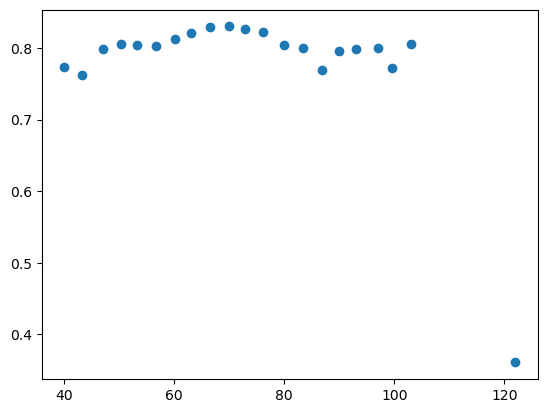

In [35]:
# Cut our tmax range into 25 bins
tmax_bins = pd.cut(data["tmax"], 25)

# Calculate the average ratio between tmax_tomorrow and tmax in each bin
ratios = (data["tmax_tomorrow"] - 11.99)/data["tmax"]
binned_ratio = ratios.groupby(tmax_bins).mean()

# Calculate the average tmax in each bin
binned_tmax = data["tmax"].groupby(tmax_bins).mean()

# Graph the tmax values versus the ratios
plt.scatter(binned_tmax, binned_ratio);

We have non-linearity present in our data.<br>
Linear regression can't quite capture nonlinearity properly. **But neural networks can!**

Neural networks add to linear regression in three important ways:

- A nonlinear transformation on top of the fundamental linear transformation
- Multiple layers, which can capture interactions between features
- Multiple hidden units, which each provide their own interpretation of the input data for further processing

## Activation Functions

Let's discuss each of these concepts separately.<br>
First, nonlinear transformations, which are called activation functions.<br>
The most common activation function used in neural networks is called the **Rectified Linear Unit**, or **ReLU**.<br>
Conceptually, ReLU is pretty straightforward. Any value below $\text{zero}$ is set to $\text{zero}$,<br>
any value above $\text{zero}$ is passed through as-is.

All of our temperature values are above $\text{zero}$, but let's generate some new temperatures to visualize the effect ReLU imposes:

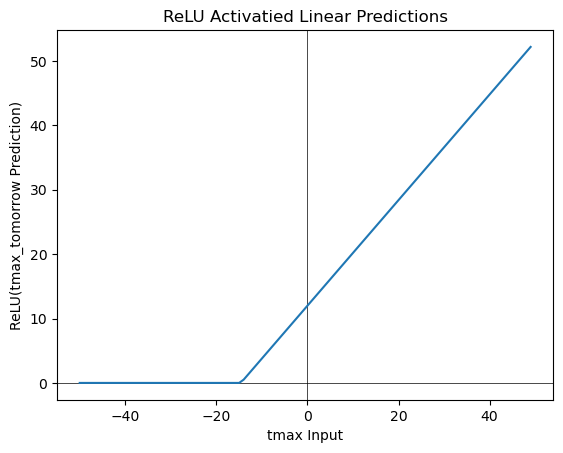

In [36]:
# Generate a range of predictions between -50 and 50.
temps = np.arange(-50, 50)


plt.axhline(0, color='black', lw=0.5)
plt.axvline(0, color='black', lw=0.5)

plt.title("ReLU Activatied Linear Predictions")
plt.xlabel("tmax Input")
plt.ylabel("ReLU(tmax_tomorrow Prediction)")

# Plot the predictions and respective ReLU activations
plt.plot(temps, np.maximum(0, prediction(temps)));

You can see that any predictions below $0$ are ReLU-squashed to $0$.<br>
This purposely induces a nonlinear relationship between the input and the prediction.<br>
In this example, if $w_{1}x_{1} + b_1$ produces a prediction of anything less than $0$, the output prediction will be squashed to $0$.<br>
If $w_{1}x_{1} + b_1$ however is greater than or equal to $0$, the prediction will just be $w_{1}x_{1} + b_1$.

> Introducing ReLU means that the prediction is no longer (thoroughly) linearly related to the input.

The equation for this looks like $\hat{y}=\text{ReLU}(w_{1}x_{1} + b) = \begin{cases} w_{1}x_{1} + b_1,& \text{if } w_{1}x_{1} + b\geq 0\\ 0, & \text{otherwise} \end{cases}$

## Multiple Layers

Of course, if all we did was add ReLU, our error would just increase.<br>
This is because we'd be forced to make the always same prediction for any temperature less than $0$.<br>
We can fix this if we add layers to add depth for our neural network.

A neural network with two layers would be formulated as: $\hat{y}=w_{2}\text{relu}(w_{1}x_{1} + b_1) + b_{2}$.

We won't use an activation function on our second layer.<br>
This output layer is the layer that we'll read our predictions from.<br>
Therefore, we should not modify/activate the output value range here.<br>
This way, we can utilize nonlinearity in our first layer, but still output a full range of values.

At least that's the plan.

While this sounds solid, our approach doesn't yet solve our problem.<br>
If our first layer $\text{relu}(w_{1}x_{1} + b_1)$ returns $0$, multiplying by any $w_{2}$ will still yield $0$.<br>
We'd only be shifting this '$0$-standard-answer' by adding $b_{2}$ to it.

Here's a concrete example, with $w_{2}$ set arbitrarily to $.5$, and $b_{2}$ set to $10$:

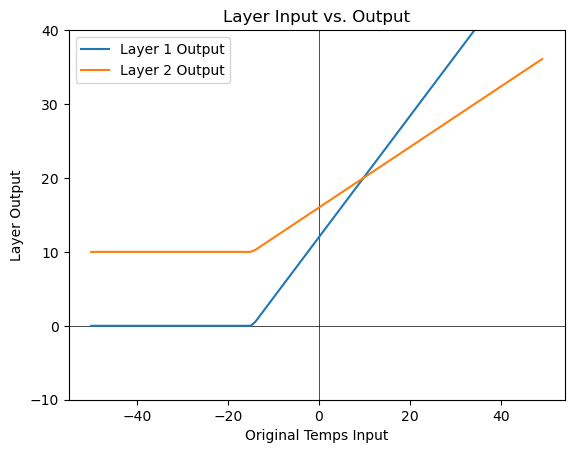

In [37]:
# Generate a range of predictions between -50 and 50.
temps = np.arange(-50,50)

# Predict tmax_tomorrow given each of our input temps
# Apply prediction twice to simulate 2 network layers
layer1 = np.maximum(0, prediction(temps))
layer2 = prediction(layer1, .5, 10)

# Descriptions
plt.title("Layer Input vs. Output")
plt.xlabel("Original Temps Input")
plt.ylabel("Layer Output")

# Plot origin lines
plt.axhline(0, color='black', lw=0.5)
plt.axvline(0, color='black', lw=0.5)

# This is what layer 1 gets vs. what it outputs
plt.plot(temps, layer1, label="Layer 1 Output")
# This is what layer 2 gets vs. what it outputs
plt.plot(temps, layer2, label="Layer 2 Output")

# Add a legend
plt.legend()

# Set the y axis of the plot to start at 0
plt.ylim((-10,40));

Predictions that consider temperatures below $\text{zero}$ have just had $b_{2} = 10$ slapped onto them.<br>
They remain non-expressive of the actual relationship between negative `tmax` and `tmax_tomorrow`.

Put differently, if `tmax` is negative, it's too unrealistic to portray `tmax_tomorrow` as always being $10$.<br>
Even though we added a layer, the quality of our predictions is therefore still poor.

## Multiple Units

We can resolve our 'non-expressive zero-nudging problem' by applying multiple individual units per layer.<br>
This essentially means running multiple linear regressions, with multiple different weights and biases.

For example, we can run linear regression twice, using slightly different weights and biases:

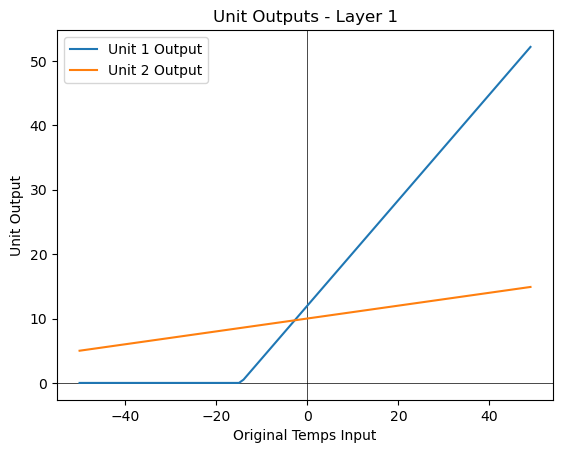

In [38]:
plt.title("Unit Outputs - Layer 1")
plt.xlabel("Original Temps Input")
plt.ylabel("Unit Output")
plt.axhline(0, color='black', lw=0.5)
plt.axvline(0, color='black', lw=0.5)

# Plot our first regression line, with w1 of .82, and b of 11.99
plt.plot(temps, np.maximum(0, prediction(temps)), label="Unit 1 Output")

# Plot our second regression line, with w1 of .1, and b of 10
plt.plot(temps, np.maximum(0, prediction(temps, .1, 10)), label="Unit 2 Output")

plt.legend();

We just plotted the graphs of two different units in the first layer of our neural network.<br>
The blue line is the output of the first unit, the orange line is the output of the second unit.

The second unit stays positive across the full range of encountered temperatures, and thus can effectively pass temperature information to the next layer. We realize a nonlinear relationship between `tmax` and the output while not just passing $0$ to the next layer for negative temperatures below $0$.<br>
We can now pass the output of both units into the second layer of the network to get a prediction.

> **Why wouldn't we then just use a single nonlinear unit that is sure to be positive across the full range of encountered temperatures?**<br>
> By using multiple units, we can learn and express different aspects of the relationship between `tmax` and `tmax_tomorrow` with each unit. This can be e.g. relationships that are only present in certain temperature ranges.

Let's take a quick look at a diagram of this neural network:

<div style="text-align:center;">
    <img src="../images/dense/2layer_network.svg" alt="Two-Layer Network">
</div>

We can code this network. Let's set:
- $w_{1} = .82$, $b_{1}= 11.99$,
- $w_{2} = .1$, $b_{2}=10$,
- $w_{3} = .5$, $w_{4} = .2$, and $b_{3}=5$.

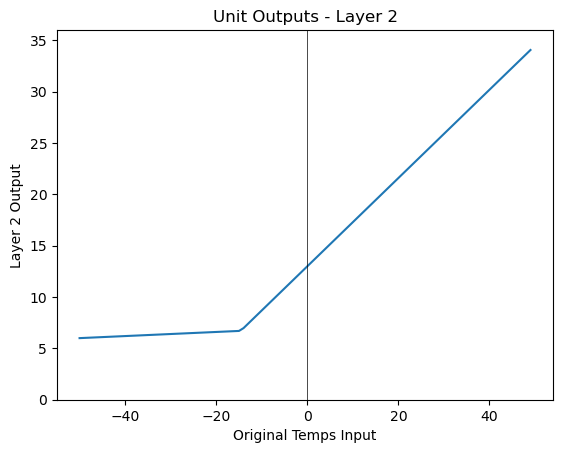

In [45]:
# Generate a range of inputs between -50 and 50.
temps = np.arange(-50, 50)

# Layer 1 unit outputs, ReLU activated
l1_u1 = np.maximum(0, prediction(temps, w=.82, b=11.99))
l1_u2 = np.maximum(0, prediction(temps, w=.1, b=10))

# Layer 2 output - multiply layer1_unit1 and layer1_unit2 by weights,
# Adding the bias seperately (b is 0 within the prediction functions)
l2 = prediction(l1_u1, w=.5, b=0) + prediction(l1_u2, w=.2, b=0) + 5

plt.plot(temps, l2)
plt.title("Unit Outputs - Layer 2")
plt.xlabel("Original Temps Input")
plt.ylabel("Layer 2 Output")
plt.axhline(0, color='black', lw=0.5)
plt.axvline(0, color='black', lw=0.5)

# Set the y axis of plot to start at 0
plt.ylim((0,36));

This looks a lot more interesting!<br>
We can see that the network doesn't make the *exact* same prediction across all input temperatures below a certain threshold. The second layer was able to look at two inputs, and the output was only (partially) zeroed out in one of them, that is the first unit in the first layer.

## Calculating Layer Outputs

In practice, dozens or hundreds of layers and units can be used in each layer.<br>
It can get annoying to have to write out $w_{1}$, $w_{2}$, and so on for all $n$ units across all layers.<br>
To make it easier to display weights and biases, and to actually pass through the network faster,<br>
we store them in matrices:

$$
\text{Inputs}\hspace{1cm}\text{Layer 1 Weights}\hspace{1cm}\text{Layer 1 Biases}\\
\begin{bmatrix}80\\90\end{bmatrix}\hspace{1.75cm}
\begin{bmatrix}.82 & .1\end{bmatrix}\hspace{1.75cm}
\begin{bmatrix}11.99 & 10\end{bmatrix}
$$

When weights are in matrices, we use matrix multiplication to multiply them with the inputs. We looked at this in more detail in the [first lesson](../1-Math_and_Numpy/linalg.ipynb). In short, matrix multiplication works by multiplying each element of each row of the first matrix by each element of each column of the second matrix, and then then adding them together:

<div style="text-align:center;">
    <img src="../images/dense/matrix_mult.gif" alt="Matrix Multiplication">
</div>

We can then add the biases to each row of the multiplication result.<br>
Here is the full process of multiplying two input `tmax` values $80$ and $90$<br>
by the weights and adding the bias.<br>
Since there are two units in layer $1$, we end up with two outputs for each input.<br>
Each row in the output corresponds to a row in the input.

$$\text{Inputs}\ \times\ \text{Layer 1 Weights} = \text{Weighted Input}\\
\begin{bmatrix}80\\90\end{bmatrix} \times 
\begin{bmatrix}.82 & .1\end{bmatrix}
=\begin{bmatrix}65.6 & 8\\ 73.8 & 9\end{bmatrix}\\
\text{}\\
\text{Weighted Input} + \text{Bias} = \text{Layer 1 Output}\\
\begin{bmatrix}65.6 & 8\\ 73.8 & 9\end{bmatrix} + \begin{bmatrix}11.99 & 10\end{bmatrix}
=\begin{bmatrix}77.59 & 18\\ 85.79 & 19\end{bmatrix}$$

The shapes of the matrices matter **a lot** in matrix multiplication.<br>
The shape is the number of rows in a matrix by the number of columns, like $2\times 1$ for a column vector.<br>

> We can only multiply matrix $A$ with matrix $B$ if the **number of columns in matrix $A$**<br>
> equals the **number of rows in matrix $B$**.

In the example output calculation above, we take a $2\times 1$ matrix of `tmax` values, multiply by a $1\times 2$ matrix of weights, then end up with a $2\times 2$ matrix. We then add a $1\times 2$ matrix to this (which adds the bias values to each row).<br>The output is a $2\times 2$ matrix.

We can implement our matrix multiplication in code:

In [60]:
# Get 5 temperature values
input = np.array([[80], [90], [100], [-20], [-10]])

# Create the weight matrix, which is 1x2
l1_weights = np.array([[.82, .1]])

# Create the 1x2 bias matrix
l1_bias = np.array([[11.99, 10]])

# This is the output of the layer
l1_output = input @ l1_weights + l1_bias

print('Input Shape:\t\t', input.shape)
print(input, "\n")

print('Layer 1 Weights Shape:\t', l1_weights.shape)
print('Layer 1 Bias Shape:\t', l1_bias.shape,"\n")
print('Output Shape:\t\t', l1_output.shape)
print(l1_output)

Input Shape:		 (5, 1)
[[ 80]
 [ 90]
 [100]
 [-20]
 [-10]] 

Layer 1 Weights Shape:	 (1, 2)
Layer 1 Bias Shape:	 (1, 2) 

Output Shape:		 (5, 2)
[[77.59 18.  ]
 [85.79 19.  ]
 [93.99 20.  ]
 [-4.41  8.  ]
 [ 3.79  9.  ]]


As you can see above, the output is a $5\times 2$ matrix, which results from the weight-scaling and the bias addition.<br> We get one output column for each unit. We now need to apply ReLU to get the final result:

In [59]:
l1_activated = np.maximum(l1_output, 0)
print(l1_activated)

[[77.59 18.  ]
 [85.79 19.  ]
 [93.99 20.  ]
 [ 0.    8.  ]
 [ 3.79  9.  ]]


We can rewrite our equation for layer $1$ to use matrices - $layer_{1}=relu(XW_{1} + B_{1})$.<br>
The capital letters indicate that we are multiplying and adding matrices, not single numbers.<br>
This equation is much simpler to look at, especially when we add in a second layer $\hat{y}=relu(XW_{1} + B_{1})W_{2} + B_{2}$.

Now, we can apply layer $2$ on top of layer $1$:

$$
\text{Layer 1 Output}\hspace{1.25cm}\text{Layer 2 Weights}\hspace{1.25cm}\text{Layer 2 Bias}\hspace{1.25cm}\text{Output}
\\
\begin{bmatrix}77.59 & 18\\ 85.79 & 19\end{bmatrix}
\hspace{1cm}\times\hspace{1cm}
\begin{bmatrix}.5\\.2\end{bmatrix}\hspace{1.5cm}+\hspace{1.5cm}5
\hspace{.75cm}=\hspace{.75cm}
\begin{bmatrix}47.395\\51.596\end{bmatrix}
$$

In [65]:
l2_weights = np.array([[.5],[.2]])
l2_bias = np.array([[5]])

output = l1_activated @ l2_weights + l2_bias

print('Layer 1 Output Shape:\t', l1_activated.shape)
print(l1_activated, "\n")

print('Layer 2 Weights Shape:\t', l2_weights.shape)
print('Layer 2 Bias Shape:\t', l2_bias.shape, "\n")

print('Layer 2 Output Shape:\t', output.shape)
print(output)

Layer 1 Output Shape:	 (5, 2)
[[77.59 18.  ]
 [85.79 19.  ]
 [93.99 20.  ]
 [ 0.    8.  ]
 [ 3.79  9.  ]] 

Layer 2 Weights Shape:	 (2, 1)
Layer 2 Bias Shape:	 (1, 1) 

Layer 2 Output Shape:	 (5, 1)
[[47.395]
 [51.695]
 [55.995]
 [ 6.6  ]
 [ 8.695]]


We attain a $5\times 1$ output where each row corresponds to a prediction.<br>
A nice way to think about neural network layers is that each layer generates new features about the data.<br>
Our input had $1$ feature `tmax`, and our first layer generated $2$ new features to describe `tmax`.<br>
Our second layer then compressed those $2$ features back into one prediction for `tmax_tomorrow`.

A good rule of thumb is that *the number of rows in the weight matrix should equal the number of columns in the input matrix*,<br>
and *the number of columns in the weight matrix should equal the number of columns in the output matrix*.<br>
So in layer $1$, our weight matrix is $1\times 2$ so we go from $1$ feature in the input to $2$ features in the output.

## Calculating W and B

We now know how to calculate the outputs of a neural network given $W$ and $B$. This is called the `forward pass` of a neural network.

Let's learn how to calculate $W$ and $B$ from the data. We'll be extending our work from the [last lesson](../2-Gradient_Descent/linreg.ipynb) with gradient descent, which helps us find the $W$ and $B$ values that have the lowest error.<br>
The difference this time is that we'll need to use **backpropagation** to transmit our loss gradient across multiple layers.

First of all, we need to calculate the loss between the actual `tmax_tomorrow` and our predictions.<br>
We can do that using squared error, with the formula $\text{SE}=(\hat{y_i} - y_i) ^ 2$.

Let's define the following `tmax` and `tmax_tomorrow` values:

In [74]:
tmax = np.array([[80], [90], [100], [-20], [-10]])
tmax_tomorrow = np.array([[83], [89], [95], [-22], [-9]])

We can then calculate the squared error between the actual `tmax_tomorrow` and the `output`:

In [75]:
se = lambda actual, predicted: (actual - predicted) ** 2
se(tmax_tomorrow, output)

array([[1267.716025],
       [1391.663025],
       [1521.390025],
       [ 817.96    ],
       [ 313.113025]])

We now have a squared error value corresponding to each of our outputs.<br>
To begin backpropagation, we need to take the derivative of squared error,<br>
which will tell us which direction we need to adjust our prediction in to lower our loss:

In [76]:
se_grad = lambda actual, predicted: predicted - actual
se_grad(tmax_tomorrow, output)

array([[-35.605],
       [-37.305],
       [-39.005],
       [ 28.6  ],
       [ 17.695]])

This tells us how to adjust each prediction to get it close to the actual value.

## Backpropagation Through Layers

Backpropagation will essentially reverse the forward pass to send the gradient to the various<br>
network parameters (weights and biases). This gradient is how the network uses gradient descent to learn.

Here is the full forward pass of the network, with the operations we'll need to reverse:

<div style="text-align:center;">
    <img src="../images/dense/fwd.svg" alt="Forward Pass">
</div>

And here is how we'll reverse them:

<div style="text-align:center;">
    <img src="../images/dense/bwd.svg" alt="Backward Pass">
</div>

Now let's start reversing our operations, starting at the top of layer $2$.

## Layer 2 Gradients

Now, we can calculate the gradient of our layer $2$ parameters relative to our output gradient.<br>
We can first get our gradient with respect to our weights by multiplying the loss gradient by the output of layer $1$:

In [78]:
output_gradient = se_grad(tmax_tomorrow, output)
l2_w_gradient =  l1_activated.T @ output_gradient
l2_w_gradient

array([[-9562.0038],
       [-1741.73  ]])

Let's discuss why this operation makes sense.<br>
In the `forward pass`, we multiply each output of layer $1$ by a weight to get the output of layer $2$.<br>
Let's use a diagram to visualize this. We'll leave the bias out to make things clearer:

<div style="text-align:center;">
    <img src="../images/dense/layer2_bw.svg" alt="Layer 2 Backward">
</div>

The diagram above shows us how the inputs are multiplied by the weights in the forward pass to get the output.<br>
As we can see, each weight is multiplied by multiple inputs.<br>
Another way to think about this is that each weight is connected to multiple inputs and to multiple outputs:

<div style="text-align:center;">
    <img src="../images/dense/layer2_bw_conn.svg" alt="Layer 2 Backward Conn">
</div>

In the backward pass, we want to know whether to increase or decrease our weights.<br>
The output gradient tells us how much each output needs to increase or decrease to reduce error.

To figure out how much each weight needs to change based on the output gradient, we need to look<br>
at each input connected to the weight, and reverse the operation we did in the forward pass.

This is because each weight affects several output values, and is scaled by several input values.<br>
So multiplying the output gradient by the inputs that the weight is connected to tells us how much<br>
changing each weight will change the outputs:

<div style="text-align:center;">
    <img src="../images/dense/layer2_bw_grad.svg" alt="Layer 2 Backward Grad">
</div>

For example if $w_{1}$ is multiplied by an input of $90$ to get one output, and by $80$ to get another<br>
output, changing $w_{1}$ will change both outputs.  But it will change them proportionally to the input.<br>
If we add $1$ to $w_{1}$, then it will increase the first output by $90$, and the second output by $80$.<br>
What we're doing in the backward pass is scaling the output gradient by the inputs to find the weight gradient.

Another way to think about it is reversing the weight connections:

<div style="text-align:center;">
    <img src="../images/dense/layer2_bw_grad_conn.svg" alt="Layer 2 Backward Grad Conn">
</div>

We transpose the layer one output matrix (the inputs to layer $2$) to ensure that each input<br>
that was connected to an output through a weight is multiplied by that output gradient.<br>
If we multiply our output gradients by the inputs to the layer, it tells us how much we<br>
need to increase or decrease our weights:

<div style="text-align:center;">
    <img src="../images/dense/layer2_grad.svg" alt="Layer 2 Grad">
</div>

This is due to the chain rule of partial derivatives, which we covered in the last lesson.<br>
If we want to find the gradient with respect to the layer $2$ weights, or $\frac{\partial L}{\partial W_{2}}$,<br>
we can write it out as a chain of multiplications:

$$\frac{\partial L}{\partial W_{2}}=\partial L\frac{\partial (XW_{2})}{\partial W_{2}}$$

In the equation above, $\partial L$ is really $\frac{\partial L}{\partial XW_{2}}$, but we just simplify<br>
it to make it easier to read. The partial derivative of the loss with respect to the layer $2$ weights is<br>
thepartial derivative of the loss with respect to the layer $2$ output $XW_{2}$ times the partial derivative<br>
of $XW_{2}$ with respect to $W_{2}$. We'll leave the bias out just to make things simpler.

We know that $\partial L$ is $XW_{2} - Y$.  $XW_{2}$ is our output prediction, and the SE gradient<br>
is`predicted - actual`.  Then we have to solve for $\frac{\partial (XW_{2})}{\partial W_{2}}$.<br>
This is just $X$, since any change to $X$ will directly change the output $XW_{2}$.

So we can say that $\frac{\partial (XW_{2})}{\partial W_{2}} = X$, and that $\frac{\partial L}{\partial W_{2}} = \partial LX$.

If you ever want to verify derivatives, you can use the Python `sympy` library:

In [86]:
from sympy import diff, symbols

# Define symbols for our equation
x, w = symbols('X, W')
# Define input times weights in sympy
sympy_output = x * w
# Take the derivative of output with respect to w
diff(sympy_output, w)

X

What we're doing in the backward pass of the neural network is using the chain rule to take<br>
the partial derivatives of each parameter with respect to the loss.

The layer $2$ bias equally affects all outputs. If we increase the bias by $5$,<br>
all of the outputs will also be increased by $5$. So the bias gradient is the average of all the output gradient values:

In [87]:
l2_b_gradient =  np.mean(output_gradient, axis=0)

l2_b_gradient

array([-13.124])

To update our layer $2$ weights and biases, we need to subtract the gradient from the $W$ and $B$ values,<br>
adjusted by the learning rate. You may recall that the learning rate prevents us from making updates to the<br>
parameters that are too large (which will move us away from the area of lowest error):

In [88]:
# Display original layer 2 weights
print(l2_weights.shape)
print(l2_weights)

(2, 1)
[[0.59562004]
 [0.2174173 ]]


In [90]:
# Set a learning rate
lr = 1e-5

# Update the bias values
l2_bias = l2_bias - l2_b_gradient * lr
# Update the weight values
l2_weights = l2_weights - l2_w_gradient * lr

print(l2_weights.shape)
print(l2_weights)

(2, 1)
[[0.78686011]
 [0.2522519 ]]


## Layer 1 Gradients

To continue backpropagation, we now need to find our loss gradient with respect to<br>
our layer $1$ outputs. Our layer $1$ outputs are scaled by the weights to get our layer $2$ output:

<div style="text-align:center;">
    <img src="../images/dense/layer2_bw.svg" alt="Layer 2 Backwards">
</div>

Another way to think about this is that each output is connected to multiple inputs through multiple weights:

<div style="text-align:center;">
    <img src="../images/dense/layer2_in_bw.svg" alt="Layer 2 Input Backwards">
</div>

To find the gradient of the loss with respect to layer $1$ output, we have to scale the output<br>
gradient by the weights (reversing the forward pass):

<div style="text-align:center;">
    <img src="../images/dense/layer2_in_bw_grad.svg" alt="Layer 2 Input Backwards Grad">
</div>

You can also think of this as reversing the connections from the forward pass:

<div style="text-align:center;">
    <img src="../images/dense/layer2_in_bw_grad_conn.svg" alt="Layer 2 Input Backwards Grad Conn">
</div>

We transpose the weights matrix to reverse the connections - every output will be multiplied by<br>
every weight connected to that output.  This tells us how much we need to change each output value<br>
in layer $1$ to reduce our loss.

We can code this operation up:

In [91]:
l1_activated_gradient = output_gradient @ l2_weights.T
print(l1_activated_gradient.shape)
print(l1_activated_gradient)

(5, 2)
[[-28.01615436  -8.9814289 ]
 [-29.35381655  -9.41025713]
 [-30.69147875  -9.83908536]
 [ 22.50419926   7.21440434]
 [ 13.92348972   4.46359737]]


## Layer 1 Parameters

Now, we can calculate the gradient with respect to the parameters in layer $1$ ($W_{1}$ and $B_{1}$).<br>
Before we do this, we have to differentiate across the nonlinear activation function.<br>
Remember that the derivative is the rate of change of a function:

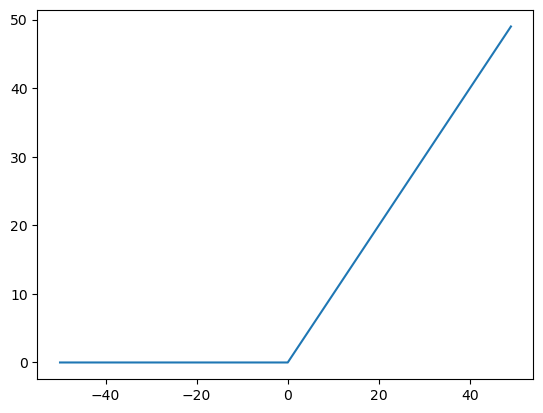

In [92]:
# Generate a range of predictions between -50 and 50.
temps = np.arange(-50,50)

# Predict tmax_tomorrow given each of our input temps
plt.plot(temps, np.maximum(0, temps));

The rate of change of the relu function is constant when the input is above $0$, and $0$ when the input is below $0$.<br>
The derivative of the relu function is undefined when the input equals $0$ (it is $1$ above and $0$ below).<br>
But by convention, we assign a derivative of $0$ to the relu function at $0$.

We can plot the derivative of the relu function:

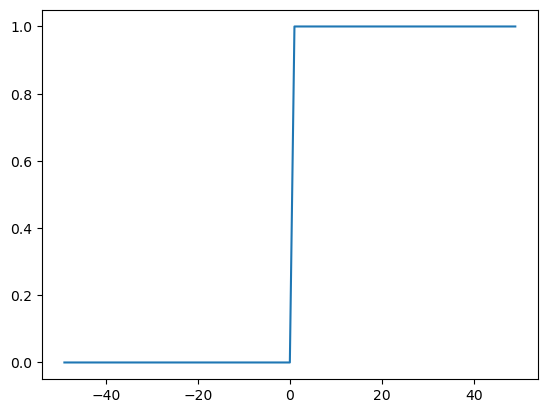

In [93]:
# Compute the relu function over the temperatures
activation = np.maximum(0, temps)

# Plot the input temperatures against the derivative of relu (the slope)
# np.roll will shift the values to the right one place, so we subtract the previous value
plt.plot(temps[1:], activation[1:] - np.roll(activation, 1)[1:]);

To get from the gradient on the activation function to the pre-nonlinearity gradient,<br>
we have to multiply the gradient by $1$ if the input is greater than $0$, and by $0$ otherwise.<br>
Intuitively, if the output of the nonlinearity was $0$ in the forward pass, then it didn't<br>
contribute to the final prediction at all. So this is making sure that we properly zero out<br>
our gradient at these points, matching what happened in the forward pass.

In [94]:
l1_output_gradient = l1_activated_gradient * np.heaviside(l1_output, 0)

print(l1_output_gradient.shape)
print(l1_output_gradient)

(5, 2)
[[-28.01615436  -8.9814289 ]
 [-29.35381655  -9.41025713]
 [-30.69147875  -9.83908536]
 [  0.           7.21440434]
 [ 13.92348972   4.46359737]]


After doing this, the layer $1$ weight and bias updates are the same as for layer $2$:

In [96]:
# Calculate gradients wrt weights and biases for layer 1
l1_w_gradient =  input.T @ l1_output_gradient
l1_b_gradient = np.mean(l1_output_gradient, axis=0)

l1_weights -= l1_w_gradient * lr
l1_bias -= l1_b_gradient * lr

print(l1_weights)
print(l1_bias)

[[0.98183037 0.1547654 ]]
[[11.99029655 10.00006621]]


At this point, we can end backpropagation, since we've computed the gradients at each of our layers.

## Backpropagation

Here is the algorithm we followed:

1. Run the network forward pass, and get the output:
2. Compute gradient with respect to the outputs of the network. (the `se_grad` function)
3. For each layer in the network:
   - Compute the gradient with respect to the pre-nonlinearity output (if the layer has a nonlinearity)
   - Compute the gradient with respect to the weights
   - Compute the gradient with respect to the biases
   - Compute the gradient with respect to the inputs to the layer
4. Update the parameters in the network using gradient descent

For convenience, we combined step $4$ into step $3$. But it's important to note that backpropagation<br>
is step $3$ above, and gradient descent is step $4$. Splitting these steps up makes it easier to use<br>
variations of regular gradient descent to update the weights (like Adam or RMSProp).

Steps $3$ and $4$ are usually called the backward pass of a neural network.

Backpropagation and gradient descent are the most complicated parts of training neural networks.<br>
Intuitively, backpropagation is about reversing the forward pass of the network so that we can<br>
figure out how to reduce error. To do this, we pass the loss gradient from layer to layer (applying the chain rule).

## Batch Size

In the example above, we used a **batch size** of $5$.<br>
This means that we did the forward and backward pass using $5$ inputs from the training dataset.<br>
Larger batch sizes will use more memory, since we need to create larger matrices.<br>
But they will also run faster, since we can process more examples at once.

Batch size also affects gradient descent. When we currently process $1$ example at a time,<br>
we do a backward pass using the gradient of that single example. With a larger batch size,<br>
we're averaging the gradient over every example in the batch when we update weights and biases.<br>
This means that we may lose some accuracy in the updates when the batch size is too high.

When the batch size is the same as the rows in the training data, then the update process<br>
is called **batched gradient descent** (confusing, I know!). Otherwise, it is called **stochastic gradient descent**.<br>
Either way, we still use backpropagation to find the gradients.

## Putting it all together

We now know enough to train a neural network to predict the weather!

Let's first load our data and split it into $3$ sets:

- A training set, which we'll use to train our algorithm
- A validation set, which we'll use to measure error during training
- A test set, which we'll use to evaluate the model after it has been fit

Creating separate sets like this helps us avoid overfitting, where our model looks great in training,<br>
but doesn't work in the real world.

In [99]:
PREDICTORS = ["tmax", "tmin", "rain"]
TARGET = "tmax_tomorrow"

# Scale our data so relu works better
# All temperature values in the original dataset are over 0, so relu won't do much for several epochs
# Scaling will make some of the input data negative
scaler = StandardScaler()
data[PREDICTORS] = scaler.fit_transform(data[PREDICTORS])

split_data = np.split(data, [int(.7 * len(data)), int(.85 * len(data))])
(train_x, train_y), (valid_x, valid_y), (test_x, test_y) = [[d[PREDICTORS].to_numpy(), d[[TARGET]].to_numpy()]
                                                            for d in split_data]

We'll train a neural network to predict `tmax_tomorrow` using `tmax`, `tmin`, and `rain`.

To train our neural network, we need $4$ elements:

- A way to initialize our parameters (weights and biases for each layer)
- A `forward` pass that computes predictions using the parameters
- A loss function that measures the error of our predictions
- A `backward` pass that updates our parameters to reduce the loss

To initialize our weight parameters, we can use random initialization.<br>
Random initialization helps the gradient descent algorithm descend to a global minimum<br>
efficiently (feel free to experiment with other initializations, like $0$ or $1$ to see what happens).

It's common to initialize the bias to be $1$ or $0$.

We'll shrink the initial parameter values so we don't end up with predictions that are<br>
too large (this can cause gradient descent to take steps that are too large).

In [100]:
def init_layers(inputs):
    layers = []
    for i in range(1, len(inputs)):
        layers.append([
            np.random.rand(inputs[i-1], inputs[i]) / 5 - .1,
            np.ones((1,inputs[i]))
        ])
    return layers

# This will initialize weights and biases for a 3-layer neural network with 10 units in the first layer, 10 in the second, and 1 in the final
# The first number (3) is our number of input features
layer_conf = [3,10,10,1]

We initialize one weight matrix and one bias matrix for each of our layers.

In the forward pass of our network, we generate outputs for each layer by<br>
multiplying $W$ and $X$, then adding $B$.  If the layer is not our output layer,<br>
we also apply a nonlinearity (relu).

The output of the last layer is our prediction for `tmax_tomorrow`:

In [101]:
def forward(batch, layers):
    hidden = [batch.copy()]
    for i in range(len(layers)):
        batch = np.matmul(batch, layers[i][0]) + layers[i][1]
        if i < len(layers) - 1:
            batch = np.maximum(batch, 0)
        # Store the forward pass hidden values for use in backprop
        hidden.append(batch.copy())
    return batch, hidden

Once we have predictions, we need to calculate error.  We have two functions, one to calculate the loss,<br>
and one to calculate the loss gradient (which helps us update our parameters):

In [102]:
def mse(actual, predicted):
    return (actual - predicted) ** 2

def mse_grad(actual, predicted):
    return predicted - actual

In the backward pass of the network, we adjust $W$ and $B$ by the gradient times learning rate.

In [103]:
def backward(layers, hidden, grad, lr):
    for i in range(len(layers)-1, -1, -1):
        if i != len(layers) - 1:
            grad = np.multiply(grad, np.heaviside(hidden[i+1], 0))

        w_grad = hidden[i].T @ grad
        b_grad = np.mean(grad, axis=0)

        layers[i][0] -= w_grad * lr
        layers[i][1] -= b_grad * lr
        
        grad = grad @ layers[i][0].T
    return layers

Finally, we'll write a loop that:

- Makes predictions for each batch (we'll use a batch size of $8$)
- Computes the gradient for each batch
- Updates the parameters based on the gradient

We will run the algorithm for several epochs - an epoch is each iteration over the training set.<br>
Up to a point, more epochs will improve the accuracy.

We will print out the loss on the validation set regularly so we can monitor the loss.<br>
We know we have too many epochs if the validation loss is increasing instead of decreasing.

In [105]:
lr = 1e-6
epochs=10
batch_size = 8

layers = init_layers(layer_conf)

for epoch in range(epochs):
    epoch_loss = []

    for i in range(0, train_x.shape[0], batch_size):
        x_batch = train_x[i:(i+batch_size)]
        y_batch = train_y[i:(i+batch_size)]
        pred, hidden = forward(x_batch, layers)

        loss = mse_grad(y_batch, pred)
        epoch_loss.append(np.mean(loss ** 2))

        layers = backward(layers, hidden, loss, lr)

    valid_preds, _ = forward(valid_x, layers)

    print(f"Epoch: {epoch} Train MSE: {mean(epoch_loss)} Valid MSE: {np.mean(mse(valid_preds,valid_y))}")

Epoch: 0 Train MSE: 3399.269611406918 Valid MSE: 1892.7122759480976
Epoch: 1 Train MSE: 408.5910737427187 Valid MSE: 26.29225981432363
Epoch: 2 Train MSE: 23.063363052505473 Valid MSE: 21.1668434105566
Epoch: 3 Train MSE: 22.35558446340396 Valid MSE: 20.830550409389996
Epoch: 4 Train MSE: 22.156749364980875 Valid MSE: 20.76567259594623
Epoch: 5 Train MSE: 22.104675155675835 Valid MSE: 20.758154449303007
Epoch: 6 Train MSE: 22.0900080688517 Valid MSE: 20.760759857449493
Epoch: 7 Train MSE: 22.084855208341967 Valid MSE: 20.763808030233914
Epoch: 8 Train MSE: 22.082348705398786 Valid MSE: 20.766043515668745
Epoch: 9 Train MSE: 22.080663771195017 Valid MSE: 20.767538846167376


We can display our final parameters from each layer:

In [106]:
layers[0]

[array([[ 0.15939215,  0.07882476,  0.13068708,  0.1170172 ,  0.18963491,
          0.03244299,  0.1628704 ,  0.13086039,  0.03705805,  0.17179876],
        [ 0.00775496,  0.04303709,  0.05725908,  0.04298319, -0.02367113,
          0.05473554, -0.00221142,  0.06583128, -0.04358214,  0.04691358],
        [ 0.02964966,  0.09148407,  0.0087103 ,  0.00050986, -0.11563738,
          0.02262268, -0.13971869,  0.05316659, -0.05406884, -0.02008104]]),
 array([[1.07513857, 1.06444725, 1.07099228, 1.08005749, 1.07170266,
         1.07708258, 1.0671098 , 1.07997027, 1.06030429, 1.07678553]])]

We can also measure error on the test set:

In [107]:
pred, hidden = forward(test_x, layers)
np.mean(mse(test_y, pred))

22.08647419775187

## Wrap-up

We learned a lot in this lesson!  You should now have a good idea of how to train a neural network with multiple layers, and use it to make predictions.  Trying changing batch size and learning rate to see how it affects the network.

In the next lesson, we'll cover how to do classification with a neural network.